## Introduction
The main idea behind this kernel is to implement DCGAN in Pytorch with some improvement techniques and implement Fretchet Inception Distance along with it. GANs are one of my favorite neural networks and one of the biggest pain points was assesing it's performance as precisely as we can do for other neural networks. Knowing when to stop the training(reaching Nash equilbirium) or comparing two GAN models was never straightforward. This drawback is overcomed by using Fretchet Inception Distance which is also considered superior to it's predecessor Inception Score.  

FID was introduced in the paper [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium
](https://arxiv.org/abs/1706.08500)

I have picked up the underlying DCGAN implementation from this [Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) and have iteratively improved upon it by some hacks discussed later and compared performance between experiments using FID which I'll also discuss later in the kernel.

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time

## Generative Adversarial Networks
A quick recap in case you don't know about GANs.

> * GANs are a class of Unsupervised Learning Algorithms that implement deep neural networks and are comprised of two parts(networks), pitting one against the other (thus the “adversarial”). These two parts are called the Generator and the Discriminator.
* The **Generator** takes the role of a forger and tries to create real images(in our case) from random noise.While the **Discriminator** takes the role of an evaluator and tries to distinguish real images from fake ones.
* The generator tries to maximize the probability of fooling the Discriminator by making the images(for example) more close to real in each step thereby making the Discriminator classify them as real.And the discriminator guides the generator to produce more realistic images , by classifying it's images as fake.
* This min-max game is continued until a [Nash equilibrium](https://www.google.com/search?q=nash+equilibrium&rlz=1C1SQJL_enIN853IN853&oq=nash+&aqs=chrome.1.69i57j0l5j69i61j69i60.5649j0j9&sourceid=chrome&ie=UTF-8) is reached.
* **DCGAN** is a variant of vanilla GAN in which Deep Convolutional layer are used in both Generator and Discriminator instead of using Dense Layers.

So let's set the seeds and some hyperparameters and get started.

In [ ]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 70
# different Learning rate for optimizers
g_lr = 0.0001
d_lr = 0.0004
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu=1

I'll be using CIFAR-10 dataset, that'll be fed to the Discriminator as real images.Let's load that.

In [ ]:
#normalizing input between -1 and 1
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0,0,0), (1,1,1)),])


dataset = dset.CIFAR10(root='../input', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


A look at the real data distribution.

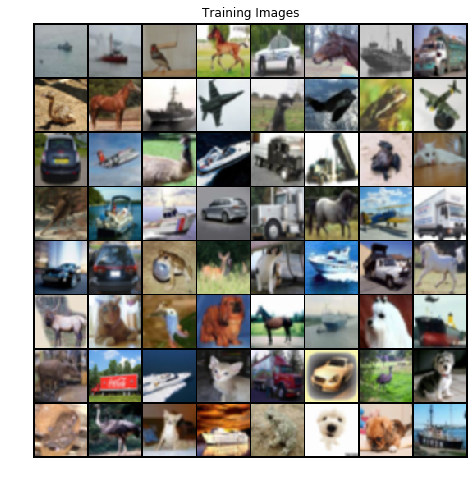

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## The Generator
* We'll start with the Generator's network first. It takes random noise from latent space(of dim 100 in our case) and maps it to an image distribution(3x64x64). These fake images along with the real images from CIFAR-10 dataset are fed into the discriminator and it outputs the probability of the image being fake or real.
* A method called [Upsampling](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) is used to produce images, we use ConvTranspose2d + stride that does the same work. Activations in every layer except the last layer is ReLu.
* Batch Normalization stabilizes learning by normalizing the input to each unit to have zero mean and unit variance. This helps deal with training problems that arise due to poor initialization and helps the gradients flow in deeper models.
* The architecture as given in the  [DCGAN paper](https://arxiv.org/abs/1511.06434).


![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

The [DCGAN paper](https://arxiv.org/abs/1511.06434) mentions that that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. These are applied to each layer of Generator and Discriminator.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

* The Discriminator is nothing but an Image classifier, that distinguishes images to be fake/real.
* It has CNNs  with leaky ReLU activations. Many activation functions will work fine with this basic GAN architecture. However, leaky ReLUs are very popular because they help the gradients flow easier through the architecture.
* Finally, it needs to output probabilities. We use a Sigmoid Activation for that.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Both the generator and discriminator are trained on Binary Cross Entropy Loss and Adam optimizer with same learning rates are used. These parameters are kept the same as the original paper except for Label Smoothing.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0
"""adding label smoothing"""
real_label=0.9
fake_label=0.1

# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))



## Fretchet Inception Distance
FID measures the distance between the Inception-v3 activation distributions for generated and real samples. But before looking into FID let's discuss a little about it's predecessor Inception Score.
### Inception Score
> The inception score computes the KL divergence between the conditional class distribution and the marginal class distribution.It measures the quality of generated images and their diversity.

Let's first talk about entropy in the sense of a random variable or a probability distribution. Entropy can be viewed as randomness. If the value of a random variable x is highly predictable, it has low entropy. On the contrary, if it is highly unpredictable, the entropy is high.Now let's look at the equation to compute IS.
![](https://miro.medium.com/max/576/1*UJ--WcXSxMKciCmHPqKlrw.png)
> 1. **Conditional Probability**:  We want the conditional probability P(y|x) to be highly predictable (low entropy). i.e. given an image, we should know the object type easily. So we use an Inception network to classify the generated images and predict P(y|x) — where y is the label and x is the generated data. This reflects the **quality** of the images.
> 2. **Marginal Probability:** The Marginal probability is computed as P(y)=
![](https://miro.medium.com/max/576/1*7e3wKMaUPYvd6HDAtXUkqA.png)
If the generated images are diverse, the data distribution for y should be uniform (high entropy).

One shortcoming for IS is that it can misrepresent the performance if it only generates one image per class. p(y) will still be uniform even though the diversity is low.

### Fretchet Inception Distance
FID is a more principled and comprehensive metric and has been shown to be more consistent with human evaluation in assessing the realism and variation of the generated samples.

The calculation can be divided into three parts:

1. We use the Inception network to extract 2048-dimensional activations from the pool3 layer for real and generated samples respectively.
2. Then we model the data distribution for these features using a multivariate Gaussian distribution with mean µ and covariance Σ. The `calculate_activation_statistics()` function does this.
3. Finally Wasserstein-2 distance is calculated for the mean and covariance of real images(x) and generated images(g).

![](https://miro.medium.com/max/576/1*tJmwViZesuFM89TcVN7J3A.png)


`calculate_fretchet_distance()` function does this.

> **Lower FID means better quality and diversity.**

The implementation is from this amazing github repo https://github.com/mseitzer/pytorch-fid

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):

        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()


        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:06, 17790287.95it/s]


In [ ]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))

    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2


    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)

     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

Now that everything is defined, let's start with the training, during which following steps are followed.
1. Batch of Images(real and fake) are fed seperately in the Discriminator(a small trick called **Mininbatch Discrimination**). First the real images from CiFAR dataset are fed, loss is calculated and gradients are backpropogated, then the same thing follows for fake images output by the generator. Once that is done the Discriminator is updated.
2. After that the Generator's cost is calculated based on the Discriminator's output. Then the Gradients are backpropogated and loss is calculated.
3. This happens in a single step of GAN.

> I'll mention some hacks that have worked for me so far:-
* Normalizing the input between -1 and 1.
* Label Smoothing.
* Lowering the learning rate(when mode collapse happened).
* Adding small noise to input to the discriminator.
* Different Learning rate for discriminator and generator.

> I've also tried the following things that didn't work quite well:-
* Dropout in Generator, Leaky Relu in Genertor.
* Less Generator updates for Discriminator updates.

There are some intuitions that you can follow while training GANs as mentioned in ganhacks:-
* If the Discriminator loss approaches 0, it's a sign of failure.
* If the loss of Generator steadily decreases, it's fooling the Discriminator with garbage.

In [ ]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))


Generator Parameters: 3576704
Discriminator Parameters: 2765568


Starting Training Loop...
[5/70]	Loss_D: 1.5292	Loss_G: 0.5024	Fretchet_Distance: 157.8501


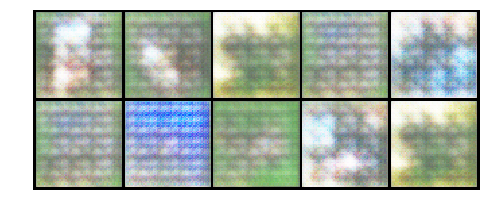

[10/70]	Loss_D: 0.8815	Loss_G: 1.8999	Fretchet_Distance: 130.3314


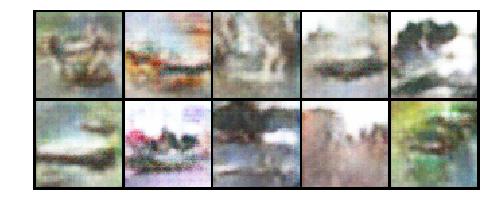

[15/70]	Loss_D: 1.2775	Loss_G: 0.5788	Fretchet_Distance: 124.5734


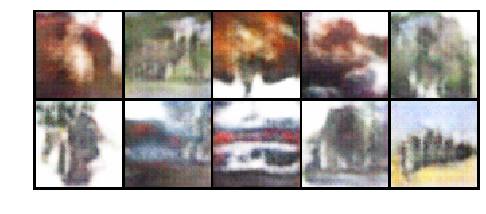

[20/70]	Loss_D: 0.8810	Loss_G: 1.5915	Fretchet_Distance: 120.4483


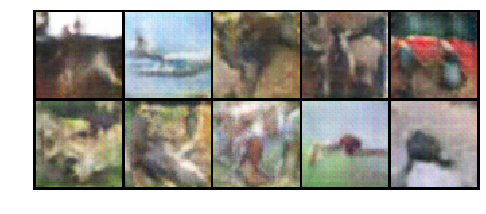

[25/70]	Loss_D: 0.9387	Loss_G: 1.3558	Fretchet_Distance: 133.2519


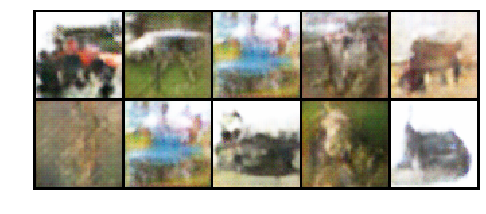

[30/70]	Loss_D: 1.0260	Loss_G: 1.0924	Fretchet_Distance: 104.4917


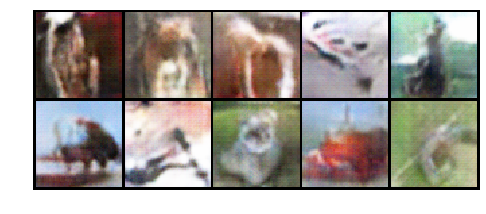

[35/70]	Loss_D: 0.8353	Loss_G: 1.8244	Fretchet_Distance: 112.6281


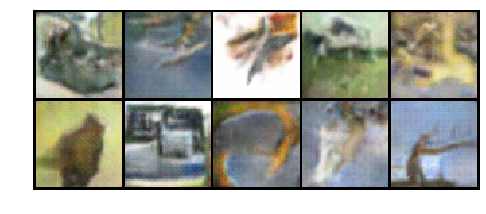

[40/70]	Loss_D: 0.9438	Loss_G: 1.0420	Fretchet_Distance: 119.5236


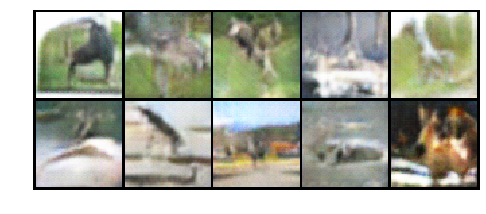

[45/70]	Loss_D: 1.0556	Loss_G: 2.8050	Fretchet_Distance: 112.0269


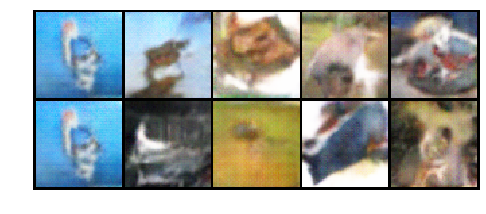

[50/70]	Loss_D: 0.9695	Loss_G: 2.6243	Fretchet_Distance: 115.8652


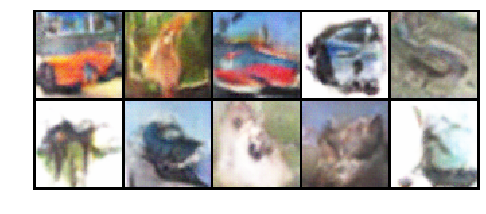

[55/70]	Loss_D: 1.0158	Loss_G: 1.1418	Fretchet_Distance: 112.0109


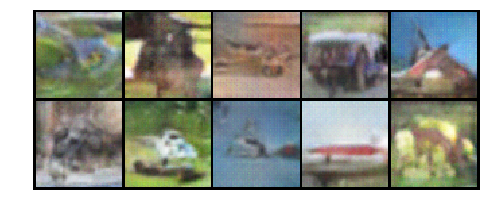

[60/70]	Loss_D: 1.0877	Loss_G: 1.0442	Fretchet_Distance: 115.4625


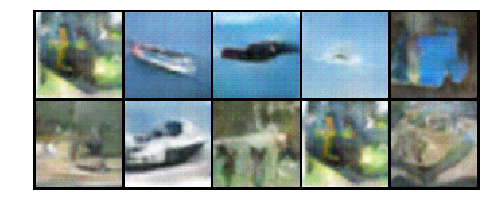

[65/70]	Loss_D: 0.8805	Loss_G: 2.9477	Fretchet_Distance: 121.3852


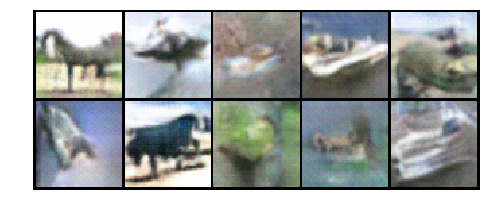

[70/70]	Loss_D: 0.7635	Loss_G: 2.1729	Fretchet_Distance: 117.3867


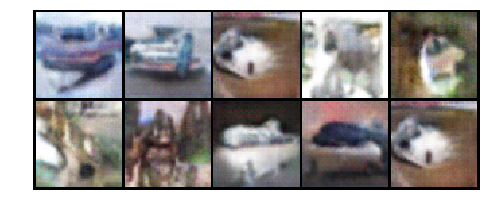

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
#         # add some noise to the input to discriminator

        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))



        iters += 1
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    fretchet_dist=calculate_fretchet(real_cpu,fake,model)
    if ((epoch+1)%5==0):

        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))


        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

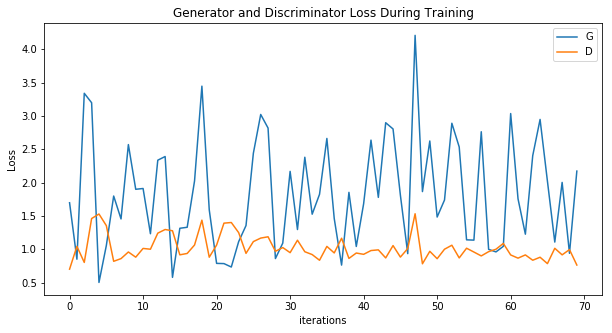

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's take a look at the images produced by the Genarator at the last iteration.


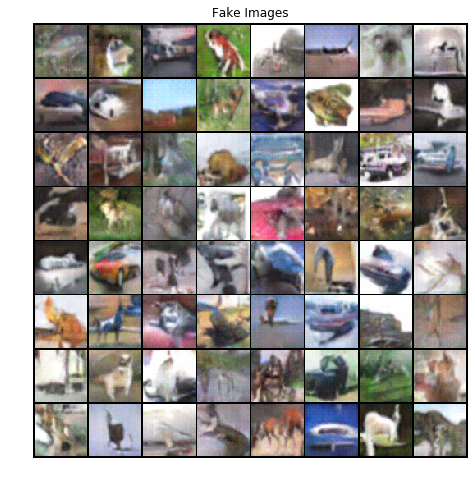

In [ ]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

You can probably spot some birds, cars, trucks or dogs in the generated images.Some points I think are worth mentioning after my experiments are:-
* It's hard to converge the model properly because we have a lot of classes(10). Images belonging to different classes have very different properties which is rather tricky for a single model to learn.
* Conditional GAN might be a good approach to implement in this case.
* Before concluding, I would like to mention that FID is sensitive to mode collapse.As mentioned in the paper [Are GANs created Equal?](https://arxiv.org/pdf/1711.10337.pdf), the metric increases for increasing modes.

![](https://miro.medium.com/max/576/1*8PzOnrzIeuM0E1unrFKLfg.png)

## References

* https://nealjean.com/ml/frechet-inception-distance/
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/soumith/ganhacks
* https://github.com/mseitzer/pytorch-fid
* https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732